<a href="https://colab.research.google.com/github/Bsingh24/CMPE-258/blob/main/symboldetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [664]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [665]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

# qam(4, True)
def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
      # creates an array of binary numbers (each number from 0 - 15 with 4 bits)
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

# CreateConstellation(qam, 4, True) -> passing into qam(4, True)
def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [666]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [667]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
# Array with complex/imaginary numbers
points.shape

(16,)

In [668]:
print(points)

[ 0.31622776+0.31622776j  0.31622776+0.94868326j  0.94868326+0.31622776j
  0.94868326+0.94868326j  0.31622776-0.31622776j  0.31622776-0.94868326j
  0.94868326-0.31622776j  0.94868326-0.94868326j -0.31622776+0.31622776j
 -0.31622776+0.94868326j -0.94868326+0.31622776j -0.94868326+0.94868326j
 -0.31622776-0.31622776j -0.31622776-0.94868326j -0.94868326-0.31622776j
 -0.94868326-0.94868326j]


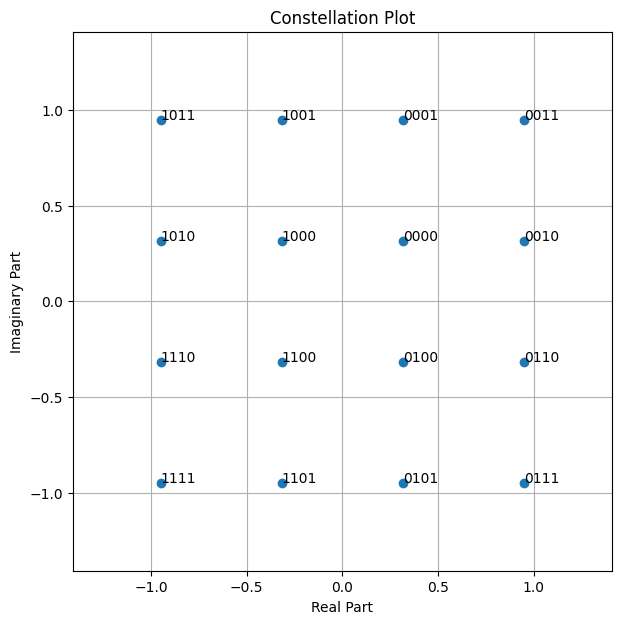

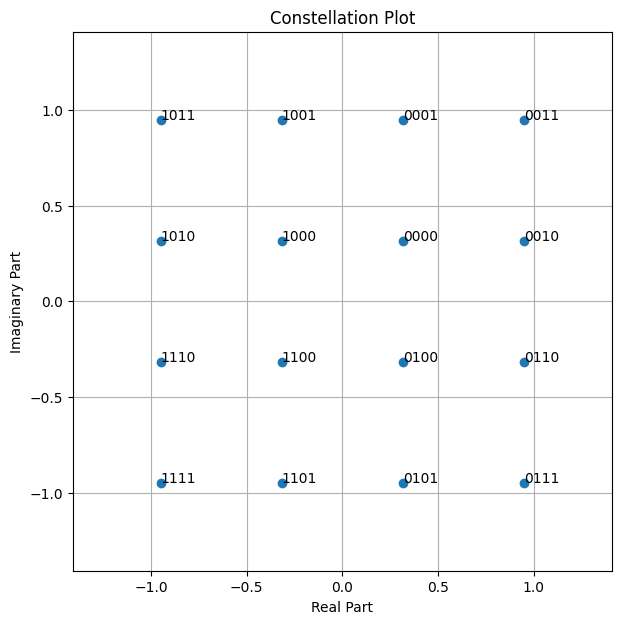

In [669]:
show(points, NUM_BITS_PER_SYMBOL)

In [670]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [671]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [672]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)

    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [673]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [674]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type # qam
        self.num_bits_per_symbol = num_bits_per_symbol # 4
        self.data_type = data_type #np.complex64
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs #numbers from -20 to 20 in 3200 intervals shuffled order

    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0)
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch

    def __len__(self):
        return len(self.ebno_dbs)

In [675]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(16,)


In [676]:
print(dataset.shape)

[64, 1024]


In [677]:
onesample = dataset[0]

In [678]:
#length of 1024
print(onesample['labels'][0])

[0. 0. 0. ... 1. 1. 0.]


In [679]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [680]:
onesample['samples'].shape

torch.Size([64, 256])

In [681]:
onesample['labels'].shape

(64, 1024)

In [682]:
# train, validation and test split
# 3200 in total
# 2560 training
# 640 validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
# Splits the dataset with number of training and validation
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
# BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
#change batch_size to 1 when running test 1-4
val_loader = DataLoader(dataset=val_set, batch_size=8, shuffle=True, pin_memory=True)

In [683]:
onebatch = next(iter(val_loader))

In [684]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [685]:
onebatch = next(iter(train_loader))

In [686]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [687]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


## Base Model: 2 Linear Layers

In [688]:
class Simplemodel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol) # 2 in, 32 out
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol) # 32 in, 4 out
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs #[64, 64, 512]

        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

## Model 2: Three Linear Layers

In [689]:
class ThreeLayerModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(ThreeLayerModel, self).__init__()
        layer2_scale = 16
        layer1_scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=layer2_scale*num_bits_per_symbol) # 2 in, 32 out
        self.linear2=nn.Linear(in_features=layer2_scale*num_bits_per_symbol, out_features=layer1_scale*num_bits_per_symbol) # 32 in, 4 out
        self.linear3=nn.Linear(in_features=layer1_scale*num_bits_per_symbol,out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs #[64, 64, 512]

        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

## Model 3: Three Layers with Dropout

In [690]:
class DropoutModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(DropoutModel, self).__init__()
        layer2_scale = 16
        layer1_scale = 8
        self.linear4=nn.Linear(in_features=2,out_features=layer2_scale*2) # 64 -> 32
        self.linear5=nn.Linear(in_features=layer2_scale*2,out_features=layer1_scale*2) # 64 -> 32
        self.linear6=nn.Linear(in_features=layer1_scale*2,out_features=num_bits_per_symbol) # 64 -> 32
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, inputs):
        y = inputs #[64, 64, 512]

        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear4(z)
        z = self.activation(z)
        z = self.linear5(z)
        z = self.dropout(z)
        z = self.activation(z)
        z = self.linear6(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        # z = self.dropout(z)
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

## Model Initializing

In [691]:
# Frame_SIZE = 64, Blocklength = 1024
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
TLayerModel = ThreeLayerModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
Dropoutmodel = DropoutModel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [692]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [693]:
output.shape

torch.Size([32, 64, 1024])

In [694]:
output.dtype

torch.float32

## Loss Function

In [695]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()

## Base Setup: SGD Optimizer with Learning Rate of 0.1

In [696]:
def Optimizer(model):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  return optimizer

## Optimizer 2: Optimizer Set to Adam with Learning Rate of 0.001

In [697]:
def Optimizer2(model):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  return optimizer

## Optimizer 3: Adam Optimizer with MultiplicativeLR

In [698]:
def Optimizer3(model):
  #lr: 0.0002
  optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.000001, lr=0.0005)
  lmbda = lambda epoch: 0.95
  scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda, verbose=True)
  return optimizer, scheduler

In [699]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [700]:
loss_fn(test,test)

tensor(0.)

In [701]:
onebatch['labels'].dtype

torch.float32

In [702]:
loss_fn(output,onebatch['labels'])

tensor(0.7124, grad_fn=<BinaryCrossEntropyBackward0>)

In [703]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [704]:
model=model.to(device)
TLayerModel=TLayerModel.to(device)
Dropoutmodel=Dropoutmodel.to(device)

## Plot Functions

In [705]:
def plot_train(train_losses, val_losses):
  # Plot Training Loss and Validation Loss
  plt.figure(figsize=(7, 3))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss Over Epochs')
  plt.grid(True)

In [706]:
def plot_BER(val_BERs):
  # Plot Validation BER
  plt.figure(figsize=(7, 3))
  plt.plot(val_BERs, label='Validation BER')
  plt.xlabel('Epochs')
  plt.ylabel('BER')
  plt.legend()
  plt.title('Bit Error Rate (BER) on validation set')
  plt.grid(True)

## Base Run

In [707]:
from tqdm.auto import tqdm

def Run(model, optimizer):
  train_losses = []
  val_losses = []
  val_BERs = []
  # Training loop
  start_epoch = 0
  num_epochs =20
  for epoch in range(start_epoch, num_epochs):
      total_loss = 0.0
      model.train()  # Set the model to training mode

      for index, data_batch in enumerate(tqdm(train_loader)):
        ''' Update here as well '''
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

      # Print average loss for the epoch
      average_loss = total_loss / len(train_loader)

      # Validation
      model.eval()  # Set the model to evaluation mode
      BER_batch=[]
      with torch.no_grad():
          for index, data_batch in enumerate(tqdm(val_loader)):
              batch = {k: v.to(device) for k, v in data_batch.items()}
              samples = batch['samples']
              labels = batch['labels']
              val_outputs = model(samples)
              val_loss = loss_fn(val_outputs, labels)

              # Convert probabilities to binary predictions (0 or 1)
              binary_predictions = torch.round(val_outputs)

              # Calculate Bit Error Rate (BER)
              error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
              error_rate = error_count / len(labels.flatten())  # Error rate calculation
              BER_batch.append(error_rate.item())

      # Save performance details
      train_losses.append(average_loss)
      val_losses.append(val_loss.item())
      BER_batch_mean=np.mean(BER_batch)
      val_BERs.append(BER_batch_mean)#(BER.item())

      # Print or log validation loss after each epoch
      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

  checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),}
  modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
  torch.save(checkpoint, modelsave_path)

  return train_losses, val_losses, val_BERs

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.6897, Val Loss: 0.6928, Val BER: 0.4303


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.6696, Val Loss: 0.6474, Val BER: 0.4080


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.6634, Val Loss: 0.7206, Val BER: 0.3967


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.6609, Val Loss: 0.6324, Val BER: 0.3912


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.6592, Val Loss: 0.6277, Val BER: 0.3910


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.6578, Val Loss: 0.6311, Val BER: 0.3839


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.6566, Val Loss: 0.6393, Val BER: 0.3870


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.6555, Val Loss: 0.6408, Val BER: 0.3839


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.6545, Val Loss: 0.7224, Val BER: 0.3805


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.6535, Val Loss: 0.7329, Val BER: 0.3833


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.6526, Val Loss: 0.6822, Val BER: 0.3811


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.6518, Val Loss: 0.6177, Val BER: 0.3774


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.6510, Val Loss: 0.6126, Val BER: 0.3782


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.6502, Val Loss: 0.6711, Val BER: 0.3778


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.6494, Val Loss: 0.7188, Val BER: 0.3755


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.6487, Val Loss: 0.6547, Val BER: 0.3742


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.6480, Val Loss: 0.6466, Val BER: 0.3746


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.6473, Val Loss: 0.6727, Val BER: 0.3734


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.6466, Val Loss: 0.6102, Val BER: 0.3744


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.6460, Val Loss: 0.6770, Val BER: 0.3716


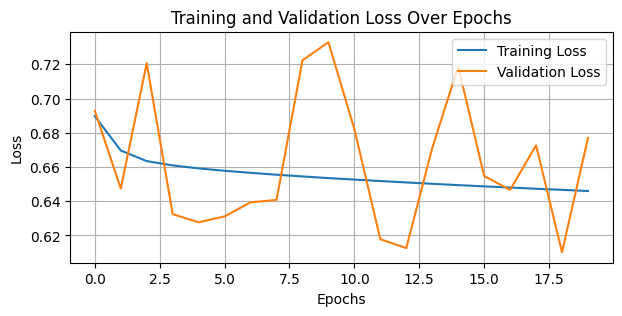

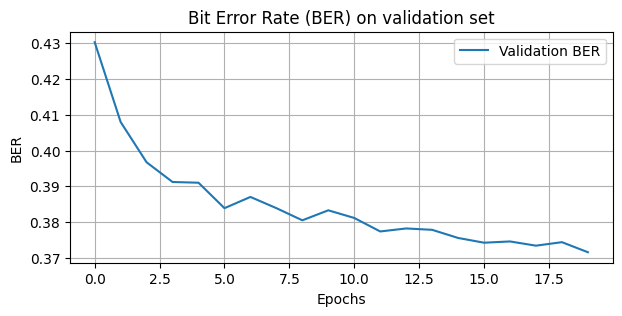

In [708]:
optimizer = Optimizer(model)
train_loss, val_loss, val_BER = Run(model, optimizer)
plot_train(train_loss, val_loss)
plot_BER(val_BER)

## Run 2: Using Adam Optimzer

In [709]:
from tqdm.auto import tqdm

def Run2(model, optimizer):
  train_losses = []
  val_losses = []
  val_BERs = []
  # Training loop
  start_epoch = 0
  num_epochs =20
  for epoch in range(start_epoch, num_epochs):
      total_loss = 0.0
      model.train()  # Set the model to training mode

      for index, data_batch in enumerate(tqdm(train_loader)):
        ''' Update here as well '''
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

      # Print average loss for the epoch
      average_loss = total_loss / len(train_loader)

      # Validation
      model.eval()  # Set the model to evaluation mode
      BER_batch=[]
      with torch.no_grad():
          for index, data_batch in enumerate(tqdm(val_loader)):
              batch = {k: v.to(device) for k, v in data_batch.items()}
              samples = batch['samples']
              labels = batch['labels']
              val_outputs = model(samples)
              val_loss = loss_fn(val_outputs, labels)

              # Convert probabilities to binary predictions (0 or 1)
              binary_predictions = torch.round(val_outputs)

              # Calculate Bit Error Rate (BER)
              error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
              error_rate = error_count / len(labels.flatten())  # Error rate calculation
              BER_batch.append(error_rate.item())

      # Save performance details
      train_losses.append(average_loss)
      val_losses.append(val_loss.item())
      BER_batch_mean=np.mean(BER_batch)
      val_BERs.append(BER_batch_mean)#(BER.item())

      # Print or log validation loss after each epoch
      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

  checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),}
  modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
  torch.save(checkpoint, modelsave_path)

  return train_losses, val_losses, val_BERs

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.6435, Val Loss: 0.5999, Val BER: 0.3643


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.6400, Val Loss: 0.6062, Val BER: 0.3602


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.6373, Val Loss: 0.6857, Val BER: 0.3558


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.6352, Val Loss: 0.5877, Val BER: 0.3539


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.6335, Val Loss: 0.7177, Val BER: 0.3523


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.6323, Val Loss: 0.6399, Val BER: 0.3492


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.6313, Val Loss: 0.5660, Val BER: 0.3493


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.6305, Val Loss: 0.6777, Val BER: 0.3486


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.6298, Val Loss: 0.5852, Val BER: 0.3476


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.6294, Val Loss: 0.5547, Val BER: 0.3473


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.6290, Val Loss: 0.7057, Val BER: 0.3467


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.6287, Val Loss: 0.7182, Val BER: 0.3461


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.6284, Val Loss: 0.6041, Val BER: 0.3460


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.6281, Val Loss: 0.7252, Val BER: 0.3461


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.6279, Val Loss: 0.5495, Val BER: 0.3458


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.6277, Val Loss: 0.5522, Val BER: 0.3458


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.6276, Val Loss: 0.7227, Val BER: 0.3454


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.6275, Val Loss: 0.7194, Val BER: 0.3456


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.6273, Val Loss: 0.5715, Val BER: 0.3453


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.6272, Val Loss: 0.7011, Val BER: 0.3453


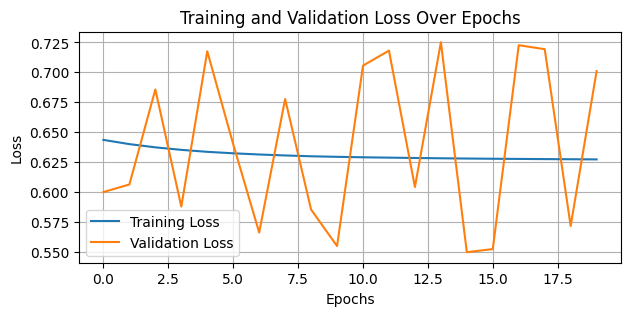

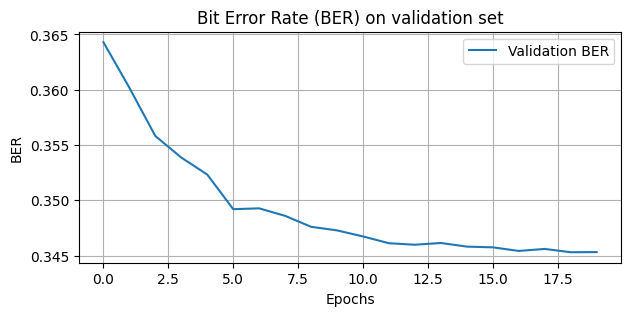

In [710]:
optimizer = Optimizer2(model)
train_loss, val_loss, val_BER = Run2(model, optimizer)
plot_train(train_loss, val_loss)
plot_BER(val_BER)

## Run 3: Adam Optimzer and MultiplicativeLR Learning Scheduler

In [711]:
from tqdm.auto import tqdm

def Run3(model, optimizer, scheduler):
  train_losses = []
  val_losses = []
  val_BERs = []
  # Training loop
  start_epoch = 0
  num_epochs =20
  for epoch in range(start_epoch, num_epochs):
      total_loss = 0.0
      model.train()  # Set the model to training mode

      for index, data_batch in enumerate(tqdm(train_loader)):
        ''' Update here as well '''
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

      # Print average loss for the epoch
      average_loss = total_loss / len(train_loader)

      # Validation
      model.eval()  # Set the model to evaluation mode
      BER_batch=[]
      with torch.no_grad():
          for index, data_batch in enumerate(tqdm(val_loader)):
              batch = {k: v.to(device) for k, v in data_batch.items()}
              samples = batch['samples']
              labels = batch['labels']
              val_outputs = model(samples)
              val_loss = loss_fn(val_outputs, labels)

              # Convert probabilities to binary predictions (0 or 1)
              binary_predictions = torch.round(val_outputs)

              # Calculate Bit Error Rate (BER)
              error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
              error_rate = error_count / len(labels.flatten())  # Error rate calculation
              BER_batch.append(error_rate.item())

      # Save performance details
      train_losses.append(average_loss)
      val_losses.append(val_loss.item())
      BER_batch_mean=np.mean(BER_batch)
      val_BERs.append(BER_batch_mean)#(BER.item())
      scheduler.step()

      # Print or log validation loss after each epoch
      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


  checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),}
  modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
  torch.save(checkpoint, modelsave_path)

  return train_losses, val_losses, val_BERs

Adjusting learning rate of group 0 to 5.0000e-04.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-04.
Epoch [1/20], Loss: 0.6271, Val Loss: 0.5723, Val BER: 0.3453


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-04.
Epoch [2/20], Loss: 0.6271, Val Loss: 0.5927, Val BER: 0.3454


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-04.
Epoch [3/20], Loss: 0.6270, Val Loss: 0.5458, Val BER: 0.3386


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-04.
Epoch [4/20], Loss: 0.6149, Val Loss: 0.5426, Val BER: 0.2873


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-04.
Epoch [5/20], Loss: 0.6049, Val Loss: 0.5205, Val BER: 0.2800


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-04.
Epoch [6/20], Loss: 0.6013, Val Loss: 0.5442, Val BER: 0.2749


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-04.
Epoch [7/20], Loss: 0.5991, Val Loss: 0.7084, Val BER: 0.2721


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-04.
Epoch [8/20], Loss: 0.5976, Val Loss: 0.7357, Val BER: 0.2704


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-04.
Epoch [9/20], Loss: 0.5964, Val Loss: 0.6912, Val BER: 0.2683


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-04.
Epoch [10/20], Loss: 0.5953, Val Loss: 0.4901, Val BER: 0.2675


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-04.
Epoch [11/20], Loss: 0.5945, Val Loss: 0.4931, Val BER: 0.2662


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-04.
Epoch [12/20], Loss: 0.5937, Val Loss: 0.7040, Val BER: 0.2653


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-04.
Epoch [13/20], Loss: 0.5931, Val Loss: 0.5300, Val BER: 0.2649


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-04.
Epoch [14/20], Loss: 0.5925, Val Loss: 0.7249, Val BER: 0.2642


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-04.
Epoch [15/20], Loss: 0.5920, Val Loss: 0.5061, Val BER: 0.2639


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-04.
Epoch [16/20], Loss: 0.5916, Val Loss: 0.7268, Val BER: 0.2631


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-04.
Epoch [17/20], Loss: 0.5912, Val Loss: 0.5282, Val BER: 0.2627


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-04.
Epoch [18/20], Loss: 0.5909, Val Loss: 0.5239, Val BER: 0.2624


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8868e-04.
Epoch [19/20], Loss: 0.5907, Val Loss: 0.6730, Val BER: 0.2620


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7924e-04.
Epoch [20/20], Loss: 0.5904, Val Loss: 0.5809, Val BER: 0.2615


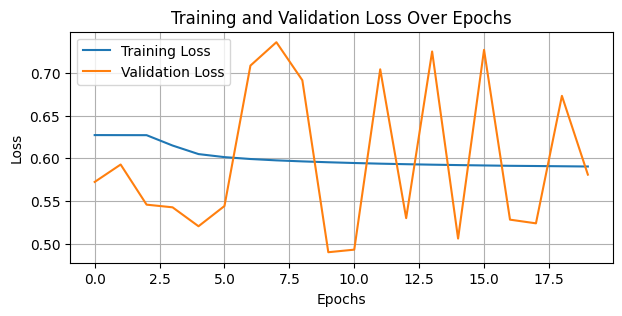

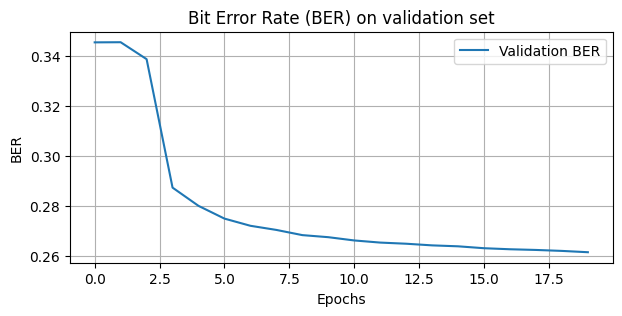

In [712]:
optimizer, scheduler = Optimizer3(model)
train_loss, val_loss, val_BER = Run3(model, optimizer, scheduler)
plot_train(train_loss, val_loss)
plot_BER(val_BER)

## Run 4: Adam Optimizer and MultiplicativeLR with 3 Layers

Adjusting learning rate of group 0 to 5.0000e-04.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-04.
Epoch [1/20], Loss: 0.6534, Val Loss: 0.5809, Val BER: 0.2024


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-04.
Epoch [2/20], Loss: 0.5933, Val Loss: 0.7882, Val BER: 0.2081


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-04.
Epoch [3/20], Loss: 0.5614, Val Loss: 0.5220, Val BER: 0.1917


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-04.
Epoch [4/20], Loss: 0.5339, Val Loss: 0.5779, Val BER: 0.1850


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-04.
Epoch [5/20], Loss: 0.5061, Val Loss: 0.3264, Val BER: 0.1820


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-04.
Epoch [6/20], Loss: 0.4829, Val Loss: 0.5419, Val BER: 0.1809


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-04.
Epoch [7/20], Loss: 0.4670, Val Loss: 0.3356, Val BER: 0.1807


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-04.
Epoch [8/20], Loss: 0.4568, Val Loss: 0.2430, Val BER: 0.1809


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-04.
Epoch [9/20], Loss: 0.4501, Val Loss: 0.2046, Val BER: 0.1809


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-04.
Epoch [10/20], Loss: 0.4454, Val Loss: 0.6923, Val BER: 0.1809


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-04.
Epoch [11/20], Loss: 0.4419, Val Loss: 0.1711, Val BER: 0.1811


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-04.
Epoch [12/20], Loss: 0.4392, Val Loss: 0.7824, Val BER: 0.1811


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-04.
Epoch [13/20], Loss: 0.4370, Val Loss: 0.6566, Val BER: 0.1809


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-04.
Epoch [14/20], Loss: 0.4352, Val Loss: 0.6091, Val BER: 0.1806


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-04.
Epoch [15/20], Loss: 0.4338, Val Loss: 0.3451, Val BER: 0.1807


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-04.
Epoch [16/20], Loss: 0.4326, Val Loss: 0.6136, Val BER: 0.1807


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-04.
Epoch [17/20], Loss: 0.4314, Val Loss: 0.7891, Val BER: 0.1807


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-04.
Epoch [18/20], Loss: 0.4306, Val Loss: 0.1377, Val BER: 0.1808


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8868e-04.
Epoch [19/20], Loss: 0.4297, Val Loss: 0.1863, Val BER: 0.1808


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7924e-04.
Epoch [20/20], Loss: 0.4290, Val Loss: 0.1526, Val BER: 0.1808


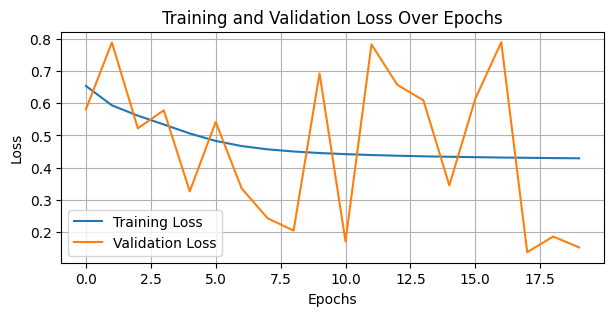

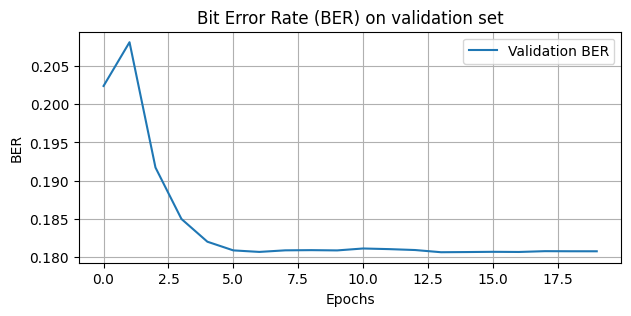

In [713]:
optimizer, scheduler = Optimizer3(TLayerModel)
train_loss, val_loss, val_BER = Run3(TLayerModel, optimizer, scheduler)
plot_train(train_loss, val_loss)
plot_BER(val_BER)

## Run 5: Adding Dropout and Removing LR Scheduler

Adjusting learning rate of group 0 to 5.0000e-04.


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.6773, Val Loss: 0.6552, Val BER: 0.3097


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.6398, Val Loss: 0.6217, Val BER: 0.2399


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.6104, Val Loss: 0.6088, Val BER: 0.2170


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.5898, Val Loss: 0.5373, Val BER: 0.2041


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.5723, Val Loss: 0.5022, Val BER: 0.1940


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.5567, Val Loss: 0.5043, Val BER: 0.1823


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.5428, Val Loss: 0.4880, Val BER: 0.1757


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.5302, Val Loss: 0.4232, Val BER: 0.1734


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.5189, Val Loss: 0.4068, Val BER: 0.1724


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.5082, Val Loss: 0.4240, Val BER: 0.1717


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.4998, Val Loss: 0.4945, Val BER: 0.1715


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.4939, Val Loss: 0.4318, Val BER: 0.1710


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.4896, Val Loss: 0.4679, Val BER: 0.1709


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.4863, Val Loss: 0.4439, Val BER: 0.1707


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.4829, Val Loss: 0.4650, Val BER: 0.1702


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.4800, Val Loss: 0.2479, Val BER: 0.1703


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.4780, Val Loss: 0.3209, Val BER: 0.1704


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.4765, Val Loss: 0.4157, Val BER: 0.1702


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.4752, Val Loss: 0.4308, Val BER: 0.1702


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.4740, Val Loss: 0.3894, Val BER: 0.1704


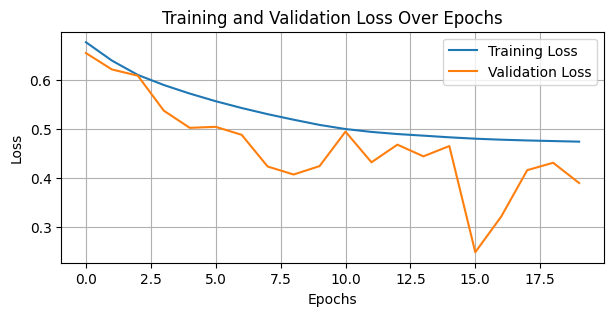

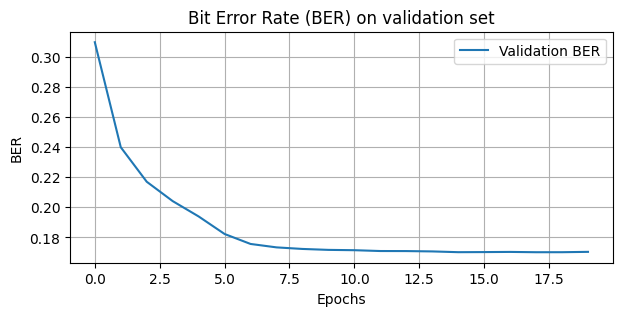

In [663]:
optimizer, s = Optimizer3(Dropoutmodel)
train_loss, val_loss, val_BER = Run2(Dropoutmodel, optimizer)
plot_train(train_loss, val_loss)
plot_BER(val_BER)